# Experiments Drawing -> Text

Idea: We want to draw something and then have a neural net reconstruct the code that generated the picture. To make it more interesting, we assume that drawing takes time. This turns it into an n:m translation problem. In fact it should become a "reverse graphics" problem. Now the question is, can we find a big hammer that "just learns" given some noisy and ambiguous input, or do we need a carefully crafted model?

We also want to explore the generative story: Given a part of the input, can the NN fill in the blanks - predict the future etc.

This is supposed to be a simple simulation experiment - in real life, for example we want to describe what's happening in a street scene in a context of 20-30 seconds, with 3D objects and different actors doing things.

Some things I want to look into:
- "classic" MT models like Bahdanau et al's.
- transformers
- DRAW
- generative models
- look at program generation perhaps
- Lecuns paper(s) on prediction
- combinations - can we have a single model that can do both translation and generation?

Also perhaps some other things I would like to get more experience on.
- pytorch. I have surprisingly little (in fact almost no) practical experience with it since most work has been done by people on my team. Especially how to deal with minibatched sequences (masks?)
- fast.ai
- looking into the model to understand more what the parts are doing.

We want to start with a minimal set of things to draw. My initial thought was to use Turtle - the part of the Logo language that deals with drawing things. But hooking a full logo interpreter in seems to be overkill. The main advantage of that would be that it would already have a LISP-like textual representation (see e.g. [here](https://www.calormen.com/jslogo/#).

So what be the most minimal version we could do? I would say

- let's start with "setpos" and "forward"
- let's not even bother with 2D - start with 1D first

Now this will of course constrain the problem a bit too much since there aren't even too many ways to present training data - the model might just memorize all combinations. But if it can't do even that it might not be worth to look further.

# Setup
We first set up a small system that can interpret drawing commands and turn them into primitive animations. We're using a super simple LISP dialect that enables us to a) use expressions in that language as our desired output, b) actually execute them and c) make sure we can later expand our language without much work. 

We use Peter Norvigs article on "LISP in Python" (http://norvig.com/lispy.html) since it contains a LISP interpreter in a few lines of code:

In [2]:
Symbol = str              # A Scheme Symbol is implemented as a Python str
Number = (int, float)     # A Scheme Number is implemented as a Python int or float
Atom   = (Symbol, Number) # A Scheme Atom is a Symbol or Number
List   = list             # A Scheme List is implemented as a Python list
Exp    = (Atom, List)     # A Scheme expression is an Atom or List
def tokenize(chars: str) -> list:
    "Convert a string of characters into a list of tokens."
    return chars.replace('(', ' ( ').replace(')', ' ) ').split()
def parse(program: str) -> Exp:
    "Read a Scheme expression from a string."
    return read_from_tokens(tokenize(program))

def read_from_tokens(tokens: list) -> Exp:
    "Read an expression from a sequence of tokens."
    if len(tokens) == 0:
        raise SyntaxError('unexpected EOF')
    token = tokens.pop(0)
    if token == '(':
        L = []
        while tokens[0] != ')':
            L.append(read_from_tokens(tokens))
        tokens.pop(0) # pop off ')'
        return L
    elif token == ')':
        raise SyntaxError('unexpected )')
    else:
        return atom(token)

def atom(token: str) -> Atom:
    "Numbers become numbers; every other token is a symbol."
    try: return int(token)
    except ValueError:
        try: return float(token)
        except ValueError:
            return Symbol(token)
import math
import operator as op

def standard_env():
    "An environment with some Scheme standard procedures."
    env = {}
    env.update(vars(math)) # sin, cos, sqrt, pi, ...
    env.update({
        '+':op.add, '-':op.sub, '*':op.mul, '/':op.truediv, 
        '>':op.gt, '<':op.lt, '>=':op.ge, '<=':op.le, '=':op.eq, 
        'abs':     abs,
        'append':  op.add,  
        'apply':   lambda proc, args: proc(*args),
        'begin':   lambda *x: x[-1],
        'car':     lambda x: x[0],
        'cdr':     lambda x: x[1:], 
        'cons':    lambda x,y: [x] + y,
        'eq?':     op.is_, 
        'equal?':  op.eq, 
        'length':  len, 
        'list':    lambda *x: list(x), 
        'list?':   lambda x: isinstance(x,list), 
        'map':     lambda *args: list(map(*args)),
        'max':     max,
        'min':     min,
        'not':     op.not_,
        'null?':   lambda x: x == [], 
        'number?': lambda x: isinstance(x, Number),   
        'procedure?': callable,
        'round':   round,
        'symbol?': lambda x: isinstance(x, Symbol),
    })
    return env

global_env = standard_env()
def eval(x: Exp, env=global_env) -> Exp:
    "Evaluate an expression in an environment."
    if isinstance(x, Symbol):        # variable reference
        return env[x]
    elif isinstance(x, Number):      # constant number
        return x                
    elif x[0] == 'if':               # conditional
        (_, test, conseq, alt) = x
        exp = (conseq if eval(test, env) else alt)
        return eval(exp, env)
    elif x[0] == 'define':           # definition
        (_, symbol, exp) = x
        env[symbol] = eval(exp, env)
    else:                            # procedure call
        proc = eval(x[0], env)
        args = [eval(arg, env) for arg in x[1:]]
        return proc(*args)

In [3]:
# Test it!
x = "(begin (define r 10) (* pi (* r r)))"
print(tokenize(x))
eval(parse(x))

['(', 'begin', '(', 'define', 'r', '10', ')', '(', '*', 'pi', '(', '*', 'r', 'r', ')', ')', ')']


314.1592653589793

^ We will try to predict streams of tokens like the above
# Drawing functions
So let's introduce a few primitives that allow us to draw. Stick to the most primitive version first - 1D:

In [4]:
import cv2 as cv
import numpy as np

In [33]:
seq = []
h, w = (1, 64)
p = np.array([0, w//2])
d = np.array([0,1]) # direction vector
def clear():
    seq = []
def curr(): 
    global seq
    return seq[-1]
def new_mat():
    global seq, h, w
    if len(seq) > 0:
        seq.append(np.copy(curr())) 
    else:
        seq.append(np.zeros((h,w)))
    return curr()

In [34]:
def clearscreen():
    global seq
    clear()
    print("clearscreen")
    return seq
def fwd(x):
    global seq, p, d
    print("forward %d" % x)
    for i in range(x):
        p += d
        new_mat()[p[0],p[1]] = 1
    return seq
def setpos(x):
    global p, seq
    p = (0,x)
    print("setpos %d %d" % (0, x))
    return seq 

global_env.update({
    'forward': fwd,
    'setpos': setpos
})

In [35]:
x = eval(parse("(begin (setpos 10) (forward 10))"))

setpos 0 10
forward 10


# Visualization
Let's make sure we can introspect the small videos as we introduce them

In [36]:
%matplotlib inline

In [37]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [38]:
def show_anim(seq):
  # First set up the figure, the axis, and the plot element we want to animate
  fig, ax = plt.subplots()
  # initialization function: plot the background of each frame
  def init():
    line.set_data([], [])
    return (line,)

  ax.set_xlim((0, w))
  ax.set_ylim((0, h))

  line, = ax.plot([], [], lw=2)
  
  def animate(i):
    img = ax.imshow(np.concatenate((seq[i], seq[i], seq[i])))
    return (img,)
  anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(seq), interval=20, blit=True)
  return HTML(anim.to_html5_video())


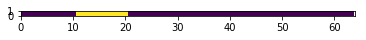

In [39]:
show_anim(x)

^ how do I get rid of the last output?
# The first Network